In [1]:
import math
from functools import partial
import scipy.integrate

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

import sys
sys.path.append('..')
# << modify sys.path to import from the parent directory

from dl.DGM import *
from equations.pdes import *
from equations.solvers import *
from pulse.pulse import Pulse2D
from pulse.utils import *
from train.trainer import *
from graphics.animation import *

../train/trainer.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


# Relativistic thin-foil electrodynamics

Sergey Rykovanov

## Theory

Primarily based on Bulanov et al, Phys. Plasmas 20, 123114 (2013)

We assume that a foil is delta-like. Ions are at the moment considered immobile and located at $x=0$. Laser pulse propagates from the left side $t-x$, everything is normalized in the usual relativistic laser-plasma way  ($e=1$, $m_e=1$, $c=1$, $\omega_L=1$). The model deals with the motion of the foil in the self-consistent way. Radiation from the foil itself is considered in the equations of motion. First, we start with the wave equation and its solutions in the case of the delta-foil.

$$\partial_{tt} \vec a - \partial_{xx} \vec a = -\alpha \delta(x-x_e(t)) \vec v\qquad (*)$$

where $x_e(t)$ is the position of 1D delta-electron, $\vec v$ - its velocity, $\alpha=n_e\, d$ is the areal density of the foil with $n_e$ - assumed density and $d$ assumed thickness (for comparison with PIC simulations).

Green function for the 1D wave equation is:

$$G(t,t',x,x')=\frac{1}{2}\Theta\left(t-t'-\left|x-x'\right| \right)\mathrm{,}$$
where $\Theta(x)$ is the Heaviside step function. Using this Green function it is easy to obtain radiation produced by the motion of the electron in 1D (Lienard-Wiechert potentials analogs):

1) observer is to the left of the foil (for transverse electric field components):

$$\vec E(t,x)=\alpha\frac{\vec{v}(t^*)}{1+v_x(t^*)}$$

It is convenient to write in components:

$$E_y(t,x)=-B_z(t,x)$$
$$E_z(t,x)=B_y(t,x)$$

2) observer is to the right of the foil

$$\vec E(t,x)=\alpha\frac{\vec{v}(t^*)}{1-v_x(t^*)}$$

$$E_y(t,x)=B_z(t,x)$$
$$E_z(t,x)=-B_y(t,x)$$

Remembering that there is a laser pulse coming from the left, and that force from self-radiation is equal to the average of fields on the both sides of the foil, the total field components can be written in the following way:

$$\epsilon\equiv\frac{\alpha}{2}$$
$$E_x=R(x)$$
$$E_y=E_{y,L}+\epsilon \frac{u_y}{\gamma}\gamma_x^2$$
$$E_z=E_{z,L}+\epsilon \frac{u_z}{\gamma}\gamma_x^2$$
$$B_x=0$$
$$B_y=-E_{z,L}-\epsilon \frac{u_x u_z}{\gamma^2}\gamma_x^2$$
$$B_z=E_{y,L}+\epsilon \frac{u_x u_y}{\gamma^2}\gamma_x^2$$

Here, $R(x)$ is the model for the restoring force of the ions, typically $R(x)=\epsilon\, \mathrm{sign}(x)$, $u$ - 4-momentum components, $\gamma_x=\frac{1}{\sqrt{1-v_x^2}}$. We can now construct the usual electromagnetic tensor and use relativistic mechanics to treat electron motion:

$$\frac{du^{\mu}}{d\tau}=-F^{\mu\nu}u_{\nu}\mathrm{,}$$
where $\tau$ is the proper time. We then get:

$$\frac{d\gamma}{d\tau}=-E_xu_x-E_{y,L}u_y-E_{z,L}u_z-\epsilon\frac{\gamma_x^2}{\gamma}\left(u_y^2+u_z^2 \right)$$
$$\frac{du_x}{d\tau}=-\gamma E_x-H_{z,L}u_y+H_{y,L}u_z-\epsilon\frac{u_x\gamma_x^2}{\gamma^2}\left(u_y^2+u_z^2 \right)$$
$$\frac{du_y}{d\tau}=-E_{y,L}\left(\gamma-u_x\right) - \epsilon u_y$$
$$\frac{du_z}{d\tau}=-E_{z,L}\left(\gamma-u_x\right) - \epsilon u_z$$


New variables:

$$\xi\equiv t-x$$
$$h\equiv\gamma-u_x$$
$$u_\perp\equiv u_y^2 + u_z^2$$

Then
$$\frac{d\xi}{d\tau}=h$$

$$u_x=\gamma-h=\frac{1+u_\perp^2-h^2}{2h}$$

After some manipulations we get:

$$\frac{dh}{d\xi}=E_x-\epsilon\frac{u_\perp^2}{1+u_\perp^2}$$
$$\frac{dx}{d\xi}=\frac{1+u_\perp^2-h^2}{2h^2}$$
$$\frac{du_y}{d\xi}=-E_{y,L}-\epsilon \frac{u_y}{h}$$
$$\frac{du_z}{d\xi}=-E_{z,L}-\epsilon \frac{u_z}{h}$$

Noticing, that $\frac{u_y}{h}=\frac{dy}{d\xi}$, we get the following set of master equations:

$$h'=E_x-\epsilon \frac{u_\perp^2}{1+u_\perp^2}$$
$$x'=\frac{1+u_\perp^2-h^2}{2h^2}$$
$$y'=\frac{u_y}{h}$$
$$z'=\frac{u_z}{h}$$
$$u_y=a_{y,L}-\epsilon y$$
$$u_z=a_{z,L}-\epsilon z$$

Below we solve these equations using RK4 method (`scipy.integrate.ode`)

Система дифференциальных ур-й
$$h'=\epsilon\left(\tanh\left(\frac{8x}{\theta}\right)-\frac{u_\perp^2}{1+u_\perp^2}\right)$$
$$x'=\frac{1+u_\perp^2-h^2}{2h^2}$$
$$y'=\frac{u_y}{h}$$
$$z'=\frac{u_z}{h}$$

Вспомогательные ур-я:
$$u_y=a_{y,L}-\epsilon y$$
$$u_z=a_{z,L}-\epsilon z$$
$$u^2_\perp = u_y^2 + u_z^2$$
Здесь $a_{y,L}$ и $a_{z,L}$ заданные цуги

## Solving simple SODEs

$$\begin{align}
    \begin{pmatrix}
    \dot x\\ \dot y\\ \dot z
    \end{pmatrix}
    =
    \begin{pmatrix}
    x+2y+2z\\ 2x+y+2z\\ 2x+2y+z
    \end{pmatrix}
\end{align}$$

$$
\mathrm w(0) = \begin{pmatrix}2\\-1\\-1\end{pmatrix}
$$

In [2]:
N = 100
net = RNNLikeDGM(1,3, as_array=False)
opt = optim.Adam(net.parameters(), 1e-3)

calc_loss = lambda t,x,y,z: torch.norm(D(x,t)-(x+2*y+2*z))
rbc = torch.tensor([2., -1., -1.])

history = []
for _ in trange(200):
    opt.zero_grad()
        
    t = torch.rand(N)
    t.requires_grad_(True)
    x,y,z = net(t).unbind(1)
    abc = net(t.new([0.]))
    
    loss = (1./N*(calc_loss(t,x,y,z)
         + calc_loss(t,y,x,z)
         + calc_loss(t,z,x,y))
         + torch.norm(rbc - abc))
    
    history.append(loss.item())
    loss.backward()
    
    opt.step()

100%|██████████| 200/200 [00:05<00:00, 35.94it/s]


<IPython.core.display.Javascript object>


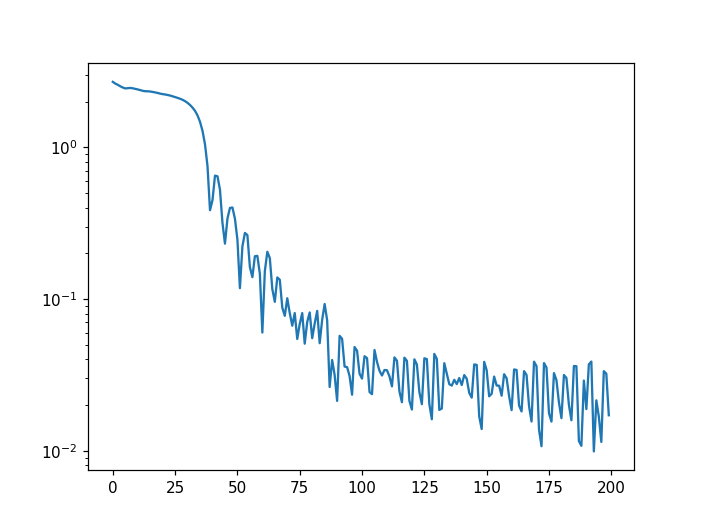

In [3]:
plt.figure()
plt.plot(history);
plt.yscale('log')

<IPython.core.display.Javascript object>


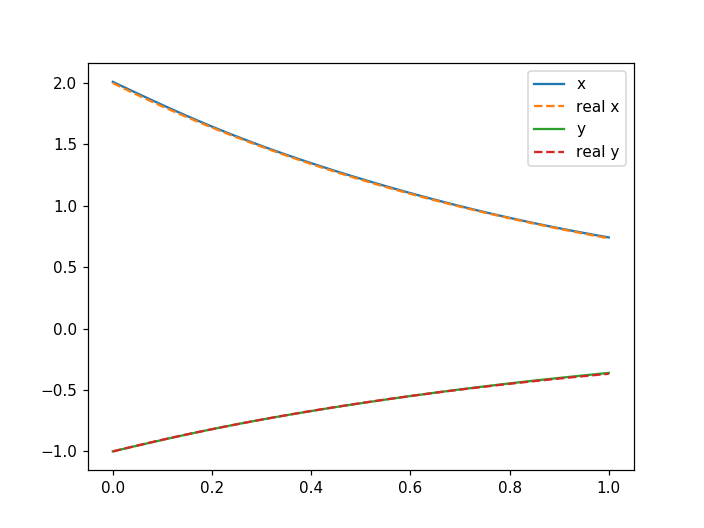

In [4]:
plt.figure()
t = torch.linspace(0, 1)

x = net(t)[:,0].detach()
rx = 2*torch.exp(-t)

y = net(t)[:,1].detach()
ry = -torch.exp(-t)

plt.plot(t, x, label='x');
plt.plot(t, rx, '--', label='real x');

plt.plot(t, y, label='y');
plt.plot(t, ry, '--', label='real y');
plt.legend();

$$\left\{\begin{align}
&\dot x = x-y^2\\
&\dot y = y\\
&\dot z = x+y^2+z\\
\end{align}\right.$$

$$
\mathrm w(0) = \begin{pmatrix}0\\1\\0\end{pmatrix}
$$

In [5]:
N = 100
net = RNNLikeDGM(1,3, growing=True, as_array=False)
opt = optim.Adam(net.parameters(), 1e-3)

rbc = torch.tensor([0., 1., 0.])
def calc_loss(t, x, y, z):
    out = (torch.norm(D(x,t) - (x-y**2))
           + torch.norm(D(y,t) - y)
           + torch.norm(D(z,t) - (x+y**2+z)))
    return out

history = []
for _ in trange(200):
    opt.zero_grad()
        
    t = torch.rand(N)
    t.requires_grad_(True)
    x,y,z = net(t).unbind(1)
    abc = net(t.new([0.]))
    
    loss = 1./N*calc_loss(t,x,y,z) + torch.norm(rbc - abc)
    history.append(loss.item())
    loss.backward()
    
    opt.step()

100%|██████████| 200/200 [00:05<00:00, 37.39it/s]


<IPython.core.display.Javascript object>


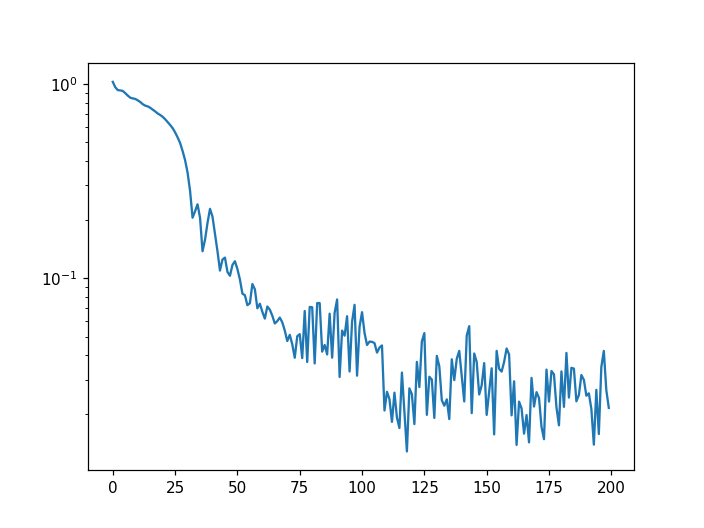

In [6]:
plt.figure()
plt.plot(history);
plt.yscale('log')

<IPython.core.display.Javascript object>


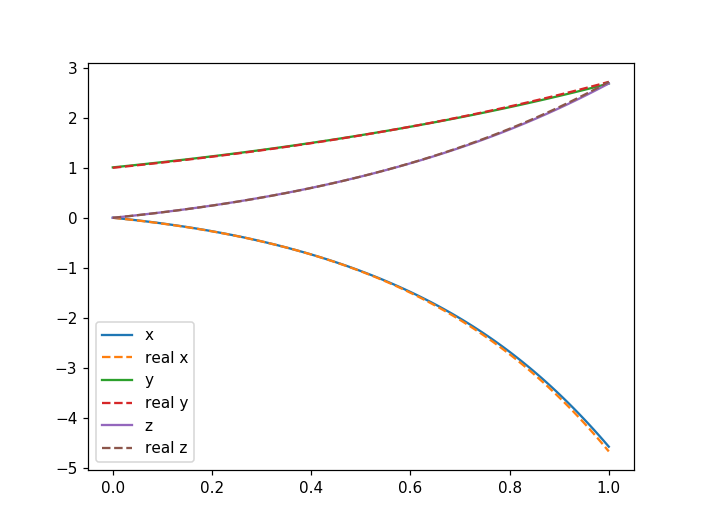

In [7]:
plt.figure()
t = torch.linspace(0, 1)

x = net(t)[:,0].detach()
rx = torch.exp(t) - torch.exp(2*t)

y = net(t)[:,1].detach()
ry = torch.exp(t)

z = net(t)[:,2].detach()
rz = t*torch.exp(t)

plt.plot(t, x, label='x');
plt.plot(t, rx, '--', label='real x');

plt.plot(t, y, label='y');
plt.plot(t, ry, '--', label='real y');

plt.plot(t, z, label='z');
plt.plot(t, rz, '--', label='real z');
plt.legend();

$$\left\{\begin{align}
&\dot x = -2x-y+37\sin t\\
&\dot y = -4x-5y\\
\end{align}\right.$$

$$
\mathrm w(0) = \begin{pmatrix}-5\\4\end{pmatrix}
$$

In [8]:
N = 200
net = RNNLikeDGM(1,2, as_array=False)
opt = optim.Adam(net.parameters(), 1e-3)

rbc = torch.tensor([-5., 4.])
def calc_loss(t, x, y, z):
    out = (torch.norm(D(x,t) - (-2*x-y+37*torch.sin(t)))
           + torch.norm(D(y,t) - (-4*x-5*y)))
    return out

history = []
for _ in trange(6000):
    opt.zero_grad()
        
    t = 10*torch.rand(N)
    t.requires_grad_(True)
    x,y = net(t).unbind(1)
    abc = net(t.new([0.]))
    
    loss = 1./N*calc_loss(t,x,y,z) + torch.norm(rbc - abc)
    history.append(loss.item())
    loss.backward()
    
    opt.step()

100%|██████████| 6000/6000 [03:05<00:00, 32.39it/s]


<IPython.core.display.Javascript object>


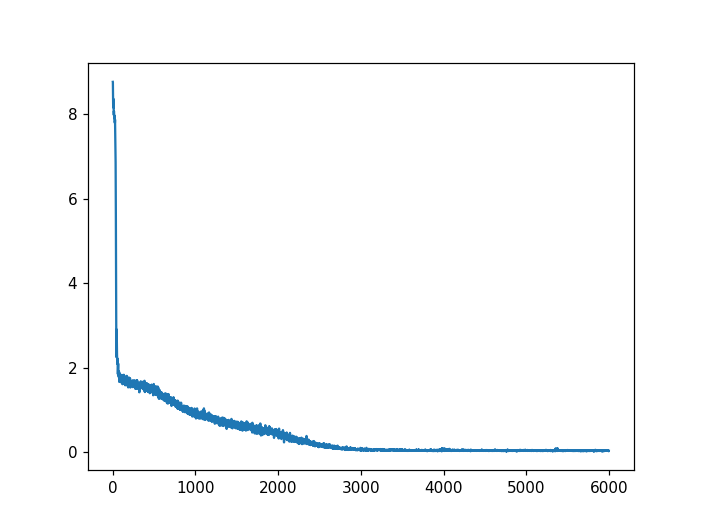

In [9]:
plt.figure()
plt.plot(history);

<IPython.core.display.Javascript object>


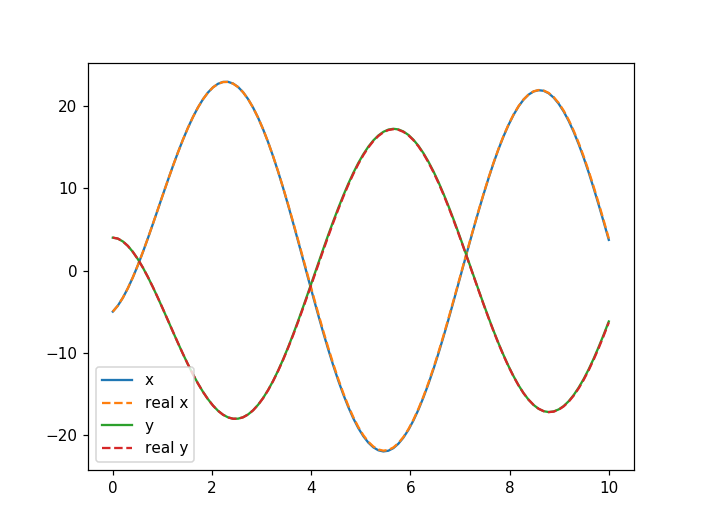

In [10]:
plt.figure()
t = 10*torch.linspace(0, 1)

x = net(t)[:,0].detach()
rx = 10*torch.exp(-t) + 16*torch.sin(t) - 15*torch.cos(t)
plt.plot(t, x, label='x');
plt.plot(t, rx, '--', label='real x');

y = net(t)[:,1].detach()
ry = -10*torch.exp(-t) - 10*torch.sin(t) + 14*torch.cos(t)
plt.plot(t, y, label='y');
plt.plot(t, ry, '--', label='real y');

plt.legend();

---

## Solving with a Neural Network

In [2]:
# --> Problem Setting
N = 500

a_0y = 20.
a_0z = 20.
xi_0y = 0.
xi_0z = .5*math.pi

tau = 10*math.pi
theta = .02*math.pi
eps = 200*theta

device = 'cuda' if torch.cuda.is_available() else 'cpu'

rbc = torch.tensor([0., 0., 0., 1.])
# <--

def pulse(x, a, phi, tau, freq=1):
    out = a * torch.sin(math.pi*x/tau)**2 * torch.sin(freq*x-tau/2+phi)
    out[x>=tau] = 0
    out[x<0] = 0
    return out

In [14]:
content = np.load('../../savings/history.npz')
history, histories = content.values()

net = RNNLikeDGM(1, 4, as_array=False)
net.load_state_dict(torch.load('../../savings/weights.pt', map_location='cpu'))

<All keys matched successfully>

In [15]:
xi = torch.linspace(0, 20*math.pi, 1000)
xyzh = net(xi)

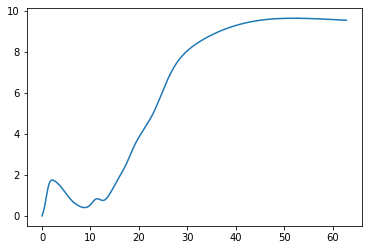

In [16]:
plt.plot(xi, xyzh[:, 0].detach());

    $a_{y,L}$ and $a_{y,L}$ are the solution projections of the homogeneous form of the equation $(*)$, that can be set as follows (like Sergey proposed it last time)

$$
    a_{y,L} = a_{0y}\exp\left(-\frac{\xi^2}{2\tau}\right)\sin(\xi + \xi_{0y})\\
    a_{z,L} = a_{0z}\exp\left(-\frac{\xi^2}{2\tau}\right)\sin(\xi + \xi_{0z})
$$

For numerical solution obtained with RK4, he uses $a$ of the following form:

$$
    a_{0y}\sin^2\frac{\pi\xi}{\tau}\;\sin(\xi-\frac{\tau}{2}+\xi_{0y})\\
    a_{0z}\sin^2\frac{\pi\xi}{\tau}\;\sin(\xi-\frac{\tau}{2}+\xi_{0z})
$$

for $\xi$ values: $0 \le \xi < \tau$ (for others it is 0)

## Numerical Solution

In [9]:
### ---> Problem Setting
dxi = 1e-4
xi_lims = (0., 20*math.pi)
n_steps = math.ceil(xi_lims[1]/dxi)+1

a_0y = 20.
a_0z = 20.
xi_0y = 0.
xi_0z = .5*math.pi
tau = 10*math.pi  # pulse duration

theta = .02*math.pi  # thickness
eps = 200*theta

rbc = torch.tensor([0., 0., 0., 1.])
### <--- Problem Setting

def pulse_np(x, A, phi, freq):
    out = A*np.sin(math.pi*x/tau)**2 * np.sin(freq*x-tau/2+phi)
    out[x>=tau] = 0
    out[x<0] = 0
    return out

def pulse_scalar(x, A, phi, tau, freq=1):
    if (x < 0) or (x>tau): return 0.
    return A*math.sin(math.pi*x/tau)**2 * math.sin(freq*x-tau/2+phi)

In [10]:
p1 = Pulse2D(pulse_scalar, ([a_0y, a_0z], [xi_0y, xi_0z], tau))
p2 = Pulse2D(pulse_scalar, ([a_0y, a_0z], [xi_0y-math.pi, xi_0z-math.pi], tau, 3))

In [11]:
solver = ThinFoilSolver(rbc, p1, eps, theta, p2)

In [12]:
xi = 20*math.pi*np.random.rand(1000)
out = solver.solve(np.sort(xi))

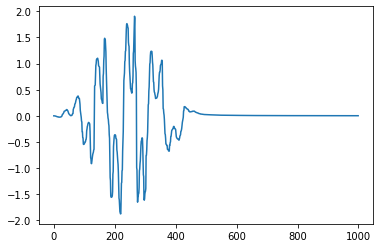

In [15]:
plt.figure()
plt.plot(out[:, 2]);

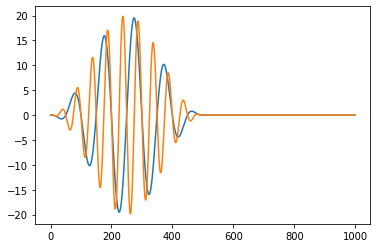

In [10]:
plt.figure()
y1 = pulse_np(torch.linspace(0, 20*math.pi, 1000), a_0y, xi_0y, tau, 1)
plt.plot(y1)
y2 = pulse(torch.linspace(0, 20*math.pi, 1000), a_0y, xi_0y, tau, 2)
plt.plot(y2);

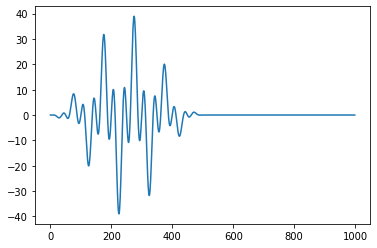

In [11]:
plt.figure()
y1 = pulse(torch.linspace(0, 20*math.pi, 1000), a_0y, xi_0y, tau, 1)
y2 = pulse(torch.linspace(0, 20*math.pi, 1000), a_0y, xi_0y-math.pi, tau, 3)
plt.plot(y1+y2);

# 4 par-s: ampl1, ampl2, dphi, ellipt
# 2 cases:
# - circular
# - linear
# E = const (conservation)

In [12]:
# scheme = 'new' ## gives a different result, probably, the improper one
scheme = 'old-fast'
# scheme = 'old-slow'

# for RK4, we assume:
# xi = t-x
# w[0] -> x(xi)
# w[1] -> y(xi)
# w[2] -> z(xi)
# w[3] -> h(xi)

# note: the restoring field is smoothed using the tanh
def force_vector(xi, w):
    a_y = pulse_scalar(xi, a_0y, xi_0y)
    a_z = pulse_scalar(xi, a_0z, xi_0z)
    u_ps = (a_y-eps*w[1])**2+(a_z-eps*w[2])**2
    E = math.tanh(8*w[0]/theta)
    #E = np.sign(8*w[0]/theta)

    f0 = .5/w[-1]**2*(1+u_ps-w[-1]**2)
    f1 = 1./w[-1]*(a_y-eps*w[1])
    f2 = 1./w[-1]*(a_z-eps*w[2])
    f3 = eps*(E - u_ps/(1+u_ps))
    return [f0,f1,f2,f3]

w = np.array([0., 0., 0., 1.], dtype='f4')
xi = np.linspace(*xi_lims, n_steps)

if scheme == 'new':
    w = scipy.integrate.solve_ivp(
        force_vector, xi_lims, w, t_eval=xi, method='RK45')
    x,y,z,h = w.y

elif scheme == 'old-fast':
    w = scipy.integrate.odeint(
        force_vector, w, xi, tfirst=True)
    x,y,z,h = w.T

elif scheme == 'old-slow':
    r=scipy.integrate.ode(force_vector, jac=None)
    r.set_integrator('dopri5')
    r.set_initial_value(w, xi_lims[0])

    while r.successful() and r.t < xi_lims[1]:
        r.integrate(r.t+dxi)
        w = np.vstack([w, r.y])
    x,y,z,h = w.T

max derivative of x: 1027.08


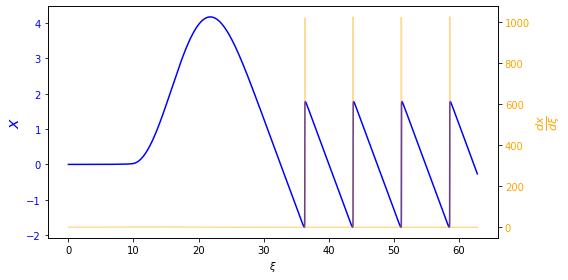

In [13]:
dx_dxi = np.gradient(x) / dxi
print(r'max derivative of x:', f'{max(dx_dxi):.2f}')

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(xi, x, c='blue')
ax1.set_ylabel(r'$x$', c='blue', size=16)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel(r'$\xi$')

ax2 = ax1.twinx()
ax2.plot(xi, dx_dxi, c='orange', alpha=.4);
ax2.set_ylabel(r'$\frac{dx}{d\xi}$', c='orange', size=16)
ax2.tick_params(axis='y', labelcolor='orange')

plt.tight_layout();

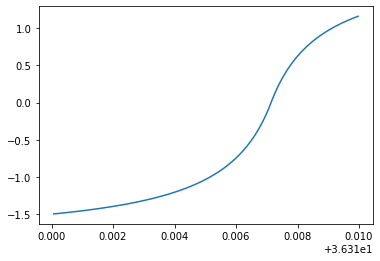

In [14]:
mask = (xi > 36.31) & (xi < 36.32)
plt.plot(xi[mask], x[mask]);

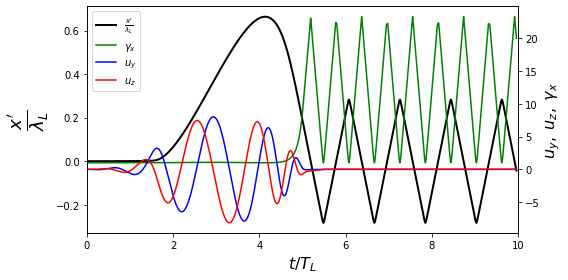

In [8]:
sw = 1.

u_x = np.gradient(x, xi) * h
u_y = np.gradient(y, xi) * h
u_z = np.gradient(z, xi) * h

gamma = np.sqrt(1 + u_x**2 + u_y**2 + u_z**2)
v_x = u_x / gamma
gamma_x = 1. / np.sqrt(1 - v_x**2)

fig, ax1 = plt.subplots(figsize=(8,4))
xaxis = xi/2/math.pi + sw*x/2/math.pi
ax1.plot(
    xaxis, x/2/math.pi, 'k',
    lw=2, label=r'$\frac{x^\prime}{\lambda_L}$')
ax1.set_xlabel(r'$t/T_L$', size=16)
ax1.set_ylabel(r'$\frac{x^\prime}{\lambda_L}$', size=26)
ax1.set_xlim(0,10)

ax2 = ax1.twinx()
ax2.plot(xaxis, gamma_x, 'g', label=r'$\gamma_x$')
ax2.plot(xaxis, u_y, 'b', label=r'$u_y$')
ax2.plot(xaxis, u_z, 'r', label=r'$u_z$')
ax2.set_ylabel(r'$u_y,\;u_z,\;\gamma_x$', size=16)

lines = ax1.lines + ax2.lines
lbls = map(lambda x: x.get_label(), lines)
plt.legend(lines, lbls, loc=0)
plt.tight_layout();

### Cells copied from the updated version

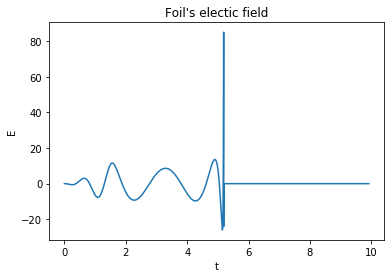

In [9]:
t = xi + x
t_detector = t + x

E_y_detector = eps * u_y / gamma / (1+v_x)
E_z_detector = eps * u_z / gamma / (1+v_x)

E_y_interp = np.interp(t, t_detector, E_y_detector)
E_z_interp = np.interp(t, t_detector, E_z_detector)

plt.plot(t_detector/2/math.pi, E_y_detector)
plt.title("Foil's electic field")
plt.ylabel('E')
plt.xlabel('t');

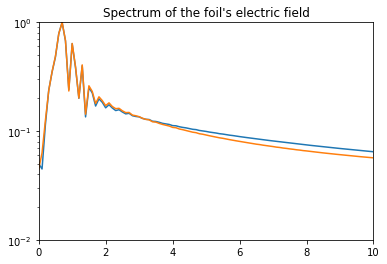

In [10]:
spectrum_y = np.fft.fft(E_y_interp)
spectrum_z = np.fft.fft(E_z_interp)

w = np.fft.fftfreq(len(E_y_interp), d=t[1]-t[0])

plt.semilogy(w*2*math.pi, abs(spectrum_y)/abs(spectrum_y).max())
plt.semilogy(w*2*math.pi, abs(spectrum_z)/abs(spectrum_z).max())

plt.title("Spectrum of the foil's electric field")
plt.ylim(1e-2,1)
plt.xlim(0,10);

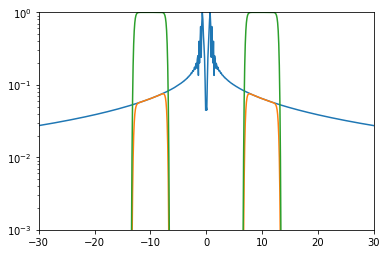

In [11]:
filter_center = 10.0
filter_width = 3.

bandgap_filter_minus = np.exp(
    -(w*2*math.pi - filter_center)**16 / filter_width**16)
bandgap_filter_plus = np.exp(
    -(w*2*math.pi + filter_center)**16 / filter_width**16)

bandgap_filter = bandgap_filter_minus + bandgap_filter_plus
plt.semilogy(w*2*math.pi, abs(spectrum_y)/abs(spectrum_y).max())
plt.semilogy(
    w*2*math.pi,
    abs(bandgap_filter*spectrum_y) / abs(spectrum_y).max())
plt.semilogy(w*2*math.pi, bandgap_filter)

sp_y_filt = bandgap_filter*spectrum_y
sp_z_filt = bandgap_filter*spectrum_z
plt.xlim(-30,30)
plt.ylim(1e-3,1);

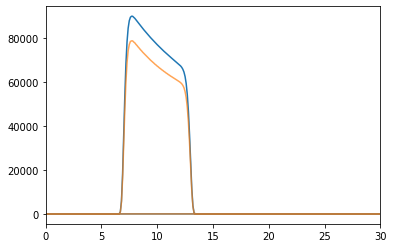

In [12]:
plt.plot(w*2*math.pi, abs(sp_y_filt))
plt.plot(w*2*math.pi, abs(sp_z_filt), alpha=.7)
plt.xlim(0,30);

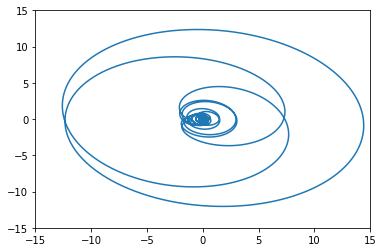

In [13]:
y_filt = np.real(np.fft.ifft(sp_y_filt))
z_filt = np.real(np.fft.ifft(sp_z_filt))

plt.plot(y_filt, z_filt)
plt.xlim(-15,15);
plt.ylim(-15,15);

# Draft